In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter

pd.set_option('display.max_columns', 120)

In [2]:
df = pd.read_csv('SA_icu_final.csv')

In [3]:
df.columns

Index(['icustay_id', 'subject_id', 'hadm_id', 'intime', 'outtime', 'dbsource',
       'icu_los', 'first_careunit', 'admittime', 'dischtime', 'hosp_deathtime',
       'admission_type', 'insurance', 'marital_status', 'diagnosis',
       'ethnic_group', 'time_spent', 'hospital_expire_flag', 'gender', 'dob',
       'dod', 'expire_flag', 'age', 'days_to_death', 'event', 'diag_category',
       'hosp_time_days'],
      dtype='object')

In [4]:
dates_cols = ['intime', 'outtime','admittime', 'dischtime', 'dob','dod', 'hosp_deathtime']
for c in dates_cols:
    df[c] = pd.to_datetime(df[c], errors = 'coerce')

In [5]:
df.dtypes

icustay_id                       int64
subject_id                       int64
hadm_id                          int64
intime                  datetime64[ns]
outtime                 datetime64[ns]
dbsource                        object
icu_los                        float64
first_careunit                  object
admittime               datetime64[ns]
dischtime               datetime64[ns]
hosp_deathtime          datetime64[ns]
admission_type                  object
insurance                       object
marital_status                  object
diagnosis                       object
ethnic_group                    object
time_spent                      object
hospital_expire_flag             int64
gender                          object
dob                     datetime64[ns]
dod                     datetime64[ns]
expire_flag                      int64
age                              int64
days_to_death                  float64
event                            int64
diag_category            

In [6]:
df.shape

(61289, 27)

In [7]:
# Keep Adults Only (Age ≥ 18)
df = df[df['age'] >= 18]

In [8]:
# Keep ONLY the First ICU Stay per Patient
'''df = df.sort_values(['subject_id', 'intime'])
df = df.groupby('subject_id', as_index=False).first() '''

"df = df.sort_values(['subject_id', 'intime'])\ndf = df.groupby('subject_id', as_index=False).first() "

In [9]:
df.shape

(53135, 27)

In [10]:
df['event'].value_counts()

event
0    29174
1    23961
Name: count, dtype: int64

In [11]:
# Exclude Organ Donors
df = df[~df['diagnosis'].str.contains('donor', case = False, na = False)]

In [12]:
df.shape

(53122, 27)

In [13]:
# In-hospital death definition (robust)
df['event_inhospital'] = (
    (df['hospital_expire_flag'] == 1) |
    (df['hosp_deathtime'].notna()) |
    (
        df['dod'].notna() &
        (df['dod'].dt.date == df['dischtime'].dt.date)
    )
).astype(int)

# Post-discharge death definition
df['event_postdischarge'] = (
    (df['event_inhospital'] == 0) &
    df['dod'].notna() &
    (df['dod'] > df['dischtime'])
).astype(int)


In [14]:
# sanity checks
print("Total rows:", len(df))
print("Unique patients:", df['subject_id'].nunique())
print("Unique icustays:", df['icustay_id'].nunique())

print("\nIn-hospital events (event_inhospital):", df['event_inhospital'].sum())
print("In-hospital censoring %:", 100*(1-df['event_inhospital'].mean()).round(4))

print("\nPost-discharge events (event_postdischarge):", df['event_postdischarge'].sum())
print("Post-discharge censoring %:", 100*(1-df['event_postdischarge'].mean()).round(4))

# Check top diag categories
print("\nTop diagnosis categories:")
print(df['diag_category'].value_counts().head(10))


Total rows: 53122
Unique patients: 38388
Unique icustays: 53122

In-hospital events (event_inhospital): 6513
In-hospital censoring %: 87.74

Post-discharge events (event_postdischarge): 17443
Post-discharge censoring %: 67.16

Top diagnosis categories:
diag_category
CARDIAC / VASCULAR                         17258
GASTROINTESTINAL / HEPATIC / PANCREATIC     6646
NEUROLOGICAL                                6581
RESPIRATORY FAILURE / PULMONARY             6041
OTHER                                       5794
SEPSIS / INFECTION                          4268
TRAUMA / SURGICAL                           2391
ONCOLOGY                                    2124
RENAL / METABOLIC                           1378
TOXIC / SUBSTANCE RELATED                    556
Name: count, dtype: int64


# Kaplan–Meier Curve — Overall Survival #

In [15]:
df['time_overall'] = np.where(
    df['expire_flag'] == 1,   # dead
    df['days_to_death'],      # event time
    df['hosp_time_days']      # censored time
)

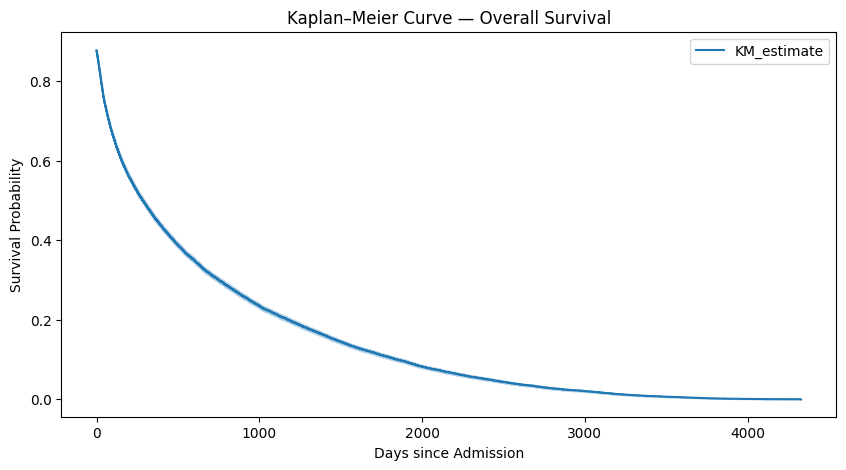

In [16]:
km = KaplanMeierFitter()

T = df['time_overall']
E = df['event']

km.fit(T, event_observed=E)

plt.figure(figsize=(10,5))
km.plot()
plt.title("Kaplan–Meier Curve — Overall Survival")
plt.xlabel("Days since Admission")
plt.ylabel("Survival Probability")
plt.savefig("SA_plots/KMC_Overall_Survival.png", dpi=300, bbox_inches='tight') 
plt.show()

# Kaplan–Meier Curves (In-Hospital) #

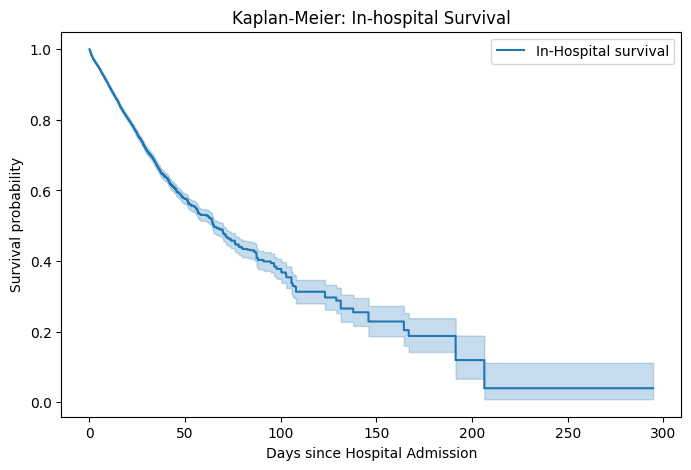

In [17]:
kmf = KaplanMeierFitter()
T = df['hosp_time_days']
E = df['event_inhospital']

kmf.fit(T, event_observed=E, label='In-Hospital survival')
plt.figure(figsize=(8,5))

ax = kmf.plot_survival_function()
ax.set_xlabel("Days since Hospital Admission")
ax.set_ylabel("Survival probability")
plt.title("Kaplan-Meier: In-hospital Survival")
plt.savefig("SA_plots/KMC_InHospital_Survival.png", dpi=300, bbox_inches='tight') 

plt.show()


# Kaplan–Meier Curves by Diagnosis Category #

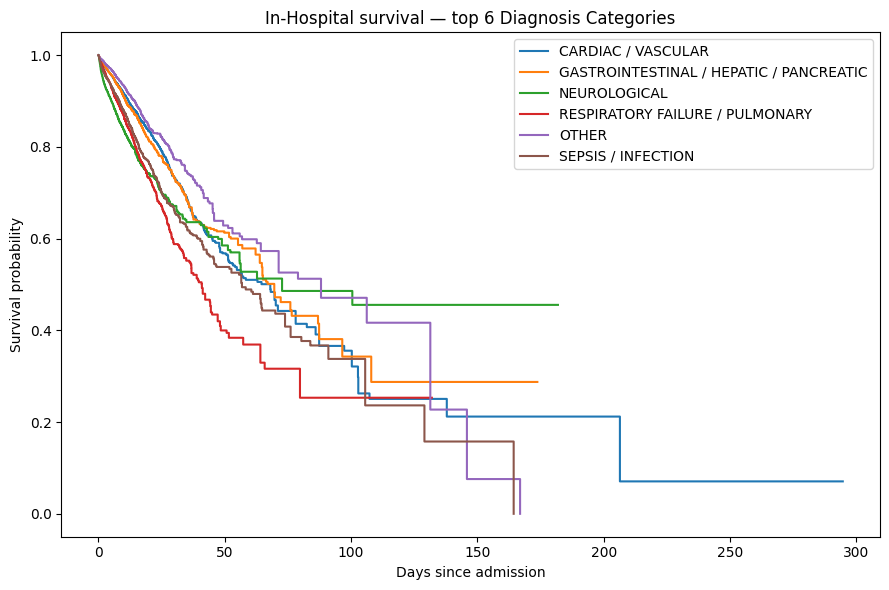

In [18]:
kmf = KaplanMeierFitter()

# KM for top-6 diag categories (in-hospital survival example)
top6 = df['diag_category'].value_counts().nlargest(6).index.tolist()
plt.figure(figsize=(9,6))
for cat in top6:
    grp = df[df['diag_category']==cat]
    kmf.fit(grp['hosp_time_days'], event_observed=grp['event_inhospital'], label=cat)
    kmf.plot_survival_function(ci_show=False)
plt.title("In-Hospital survival — top 6 Diagnosis Categories")
plt.xlabel("Days since admission")
plt.ylabel("Survival probability")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("SA_plots/KMC_Top6_DiagCat.png", dpi=300, bbox_inches='tight') 
plt.show()

# Kaplan–Meier Curves by Age Bins 

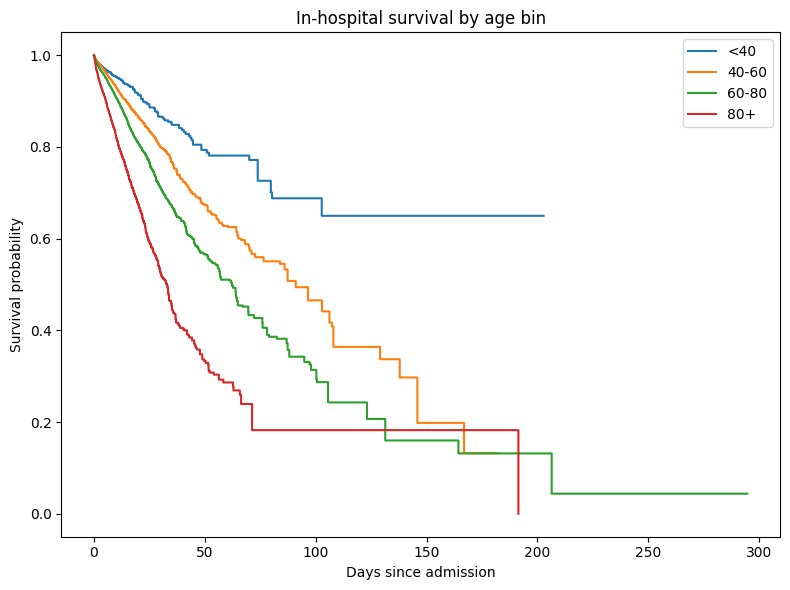

In [19]:
# KM by age bins
bins = [0,40,60,80,200]
labels = ['<40','40-60','60-80','80+']
df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(8,6))
for lab in labels:
    grp = df[df['age_bin']==lab]
    if len(grp) < 10: 
        continue
    kmf.fit(grp['hosp_time_days'], event_observed=grp['event_inhospital'], label=str(lab))
    kmf.plot_survival_function(ci_show=False)
plt.title("In-hospital survival by age bin")
plt.xlabel("Days since admission")
plt.ylabel("Survival probability")
plt.legend()
plt.tight_layout()
plt.savefig("SA_plots/KMC_Age_Bins.png", dpi=300, bbox_inches='tight') 
plt.show()

# COX PH

In [35]:
df2 = df.copy()

# 1. Create Dummies
df2 = pd.get_dummies(
    df2,
    columns=[
        'gender',
        'first_careunit',
        'diag_category',
        'admission_type',
    ],
    drop_first=True
)

# 2. Build Covariate List
dummy_prefixes = (
    "gender_",
    "first_careunit_",
    "diag_category_",
    "admission_type_",
)

covariates = ['age', 'icu_los'] + [
    col for col in df2.columns if col.startswith(dummy_prefixes)
]

# 3. Fit Cox PH Model
cox = CoxPHFitter()

cox.fit(
    df2[['hosp_time_days', 'event', 'subject_id'] + covariates],
    duration_col='hosp_time_days',
    event_col='event',
    cluster_col='subject_id'
)

cox.print_summary()


<lifelines.CoxPHFitter: fitted with 53122 total observations, 29166 right-censored observations>
             duration col = 'hosp_time_days'
                event col = 'event'
              cluster col = 'subject_id'
          robust variance = True
      baseline estimation = breslow
   number of observations = 53122
number of events observed = 23956
   partial log-likelihood = -228473.94
         time fit was run = 2025-11-25 15:35:38 UTC

---
                                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                              
age                                                    0.03      1.03      0.00            0.03            0.03                1.03                1.03
icu_los                                               -0.05      0.95      0.00           -0.05           -0.05                0.95                0.95
gender_M                                               0.01      1.01      0.02           -0.03            0.05                0.97                1.05
first_careunit_CSRU                                   -0.67      0.51      0.03           -0.73           -0.62                0.48                0.54
first_careunit_MICU                                   -0.02      0.98      0.02           -0.06            0.03                0.94                1.03
first_careunit_SICU                                   -0.35      0.71      0.03           -0.40           -0.29                0.67                0.75
first_careunit_TSICU                                  -0.39      0.67      0.03           -0.46           -0.33                0.63                0.72
diag_category_FAILURE TO THRIVE / MISC                -0.66      0.51      0.19           -1.04           -0.29                0.35                0.75
diag_category_GASTROINTESTINAL / HEPATIC / PANCREATIC -0.06      0.94      0.03           -0.12            0.01                0.89                1.01
diag_category_NEUROLOGICAL                             0.13      1.14      0.03            0.06            0.19                1.06                1.21
diag_category_ONCOLOGY                                -0.06      0.95      0.05           -0.16            0.05                0.85                1.05
diag_category_OTHER                                   -0.18      0.83      0.03           -0.25           -0.12                0.78                0.89
diag_category_RENAL / METABOLIC                       -0.04      0.96      0.06           -0.16            0.08                0.85                1.08
diag_category_RESPIRATORY FAILURE / PULMONARY          0.22      1.25      0.03            0.16            0.28                1.18                1.32
diag_category_SEPSIS / INFECTION                      -0.06      0.94      0.04           -0.14            0.01                0.87                1.01
diag_category_TOXIC / SUBSTANCE RELATED               -0.10      0.91      0.15           -0.39            0.19                0.68                1.21
diag_category_TRAUMA / SURGICAL                       -0.20      0.81      0.05           -0.30           -0.11                0.74                0.90
admission_type_EMERGENCY                               0.16      1.17      0.03            0.10            0.22                1.10                1.24
admission_type_URGENT                                  0.16      1.17      0.06            0.05            0.27                1.05                1.31

                                                       cmp to      z      p  -log2(p)
covariate                                                                            
age                                                      0.00  32.98 <0.005    789.94
icu_los                                                  0.00 -41.06 <0.005       inf
gender_M   